# Research Project

Start Anaconda by typing this in the console: 

conda activate env_name
jupyter notebook

In [27]:
import sklearn
from sklearn.metrics    import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn            import preprocessing
from sklearn.utils      import shuffle
import requests
import numpy as np
import io
from glob import glob

import pandas as pd
import matplotlib.pyplot as pyplot
from IPython.display import Image
import os
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import imageio as iio

# first run the following command: pip install geemap
import geemap

# First, run the following command: pip install earthengine-api --upgrade
import ee

#first run the following command: pip install opencv-python
import cv2



from keras import models
from keras import layers
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split


#first run the following command: pip install --user albumentations
from albumentations import HorizontalFlip, GridDistortion, OpticalDistortion, ChannelShuffle, CoarseDropout, CenterCrop, Crop, Rotate, VerticalFlip



import pandas as pd

from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)



import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf



In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AVHEtk41Qa04wdQW9Y4h3twQ1KU8jCGskgKTNOHKYqfiWhpWgBxds8VaelU

Successfully saved authorization token.


## Showing the Peruvian spill on the Map

In [3]:
imgVV = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.eq('instrumentMode', 'IW')).select('VV')
location=(-11.92048,-77.142699)

desc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
asc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

#pre spill
#spill = ee.Filter.date('2021-12-20', '2022-01-14')
#post spill
spill = ee.Filter.date('2022-01-15', '2022-01-30')

        
img = ee.Image.cat(imgVV.filter(spill).mean())


# Set map to center on incident location
Map = geemap.Map(center=location, zoom=10)
Map.add_basemap('SATELLITE')
Map.addLayer(img, vis_params={'min': -25, 'max': 5, 'palette': ['black', 'white']}, shown=True, name='Multi-T Mean VV', opacity=1.0)
# A point representing the general location of the incident.
Map.add_layer(Marker(location=location))
Map.add_layer(ee.Geometry.BBox(-77.342699, -12.120481, -76.942699, -11.720481))


Map

Map(center=[-11.92048, -77.142699], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

Creating an numpy array based on the image of the spill

In [4]:
roi = ee.Geometry.BBox(-77.342699, -12.120481, -76.942699, -11.720481)

In [5]:
#image = ee.Image.sampleRectangle(image=img, region=roi)
image = ee.Image.unitScale(input = img, low = -25, high = 5)


In [6]:
url = image.getDownloadUrl({
    'bands': ['VV'],
    'region': roi,
    'scale': 100,
    'format': 'NPY'
})
response = requests.get(url)
npyimage = np.load(io.BytesIO(response.content))

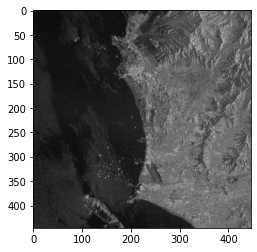

In [7]:
# Reshape the data into a 2D array
rows = npyimage.shape[0]
cols = npyimage.shape[1]
data = np.reshape(npyimage, (rows, cols,))

# Plot the image
data  = data.astype('float64')
#data = data / 255

plt.imshow(data, cmap='gray')
plt.show()

## Training and Testing a model using the Krestenitis Dataset

### Loading the Dataset

Loading all the different images of the dataset and plotting a few examples

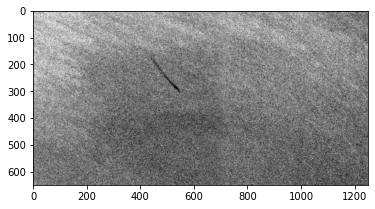

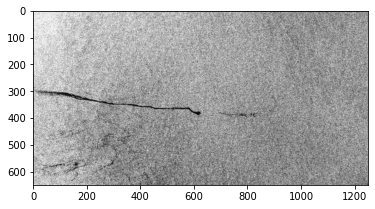

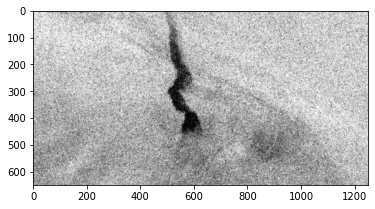

In [16]:
X_train = []
for im_path in glob.glob("oil-spill-detection-dataset/train/images/*.jpg"):
    X = iio.imread(im_path)
    X_train.append(X)
#    X_train.append((X[:, :, :1]).reshape(650, 1250)) #to only select the gray scale once

    
plt.imshow(X_train[0], cmap='gray')
plt.show()
plt.imshow(X_train[1], cmap='gray')
plt.show()
plt.imshow(X_train[2], cmap='gray')
plt.show()


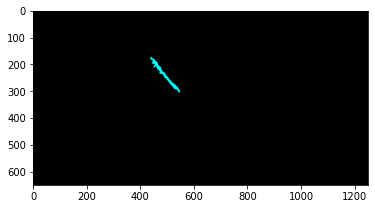

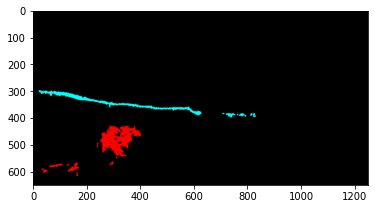

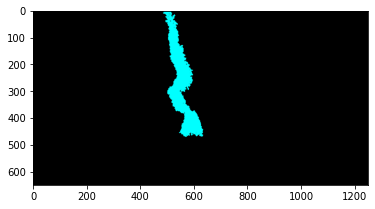

In [3]:
Y_train = []

for im_path in glob.glob("oil-spill-detection-dataset/train/labels/*.png"):
    Y = iio.imread(im_path)
    Y_train.append(Y)
    
plt.imshow(Y_train[0])
plt.show()
plt.imshow(Y_train[1])
plt.show()
plt.imshow(Y_train[2])
plt.show()


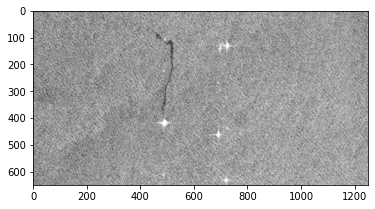

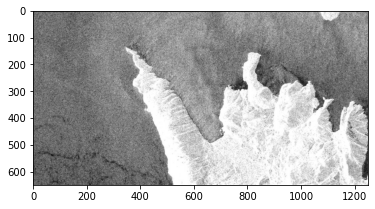

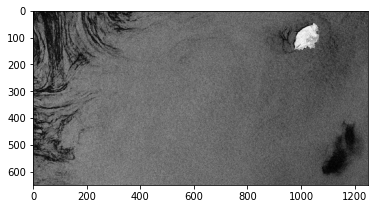

In [14]:
X_test = []
for im_path in glob.glob("oil-spill-detection-dataset/test/images/*.jpg"):
    X = iio.imread(im_path)
    X_test.append(X)
#    X_test.append((X[:, :, :1]).reshape(650, 1250)) #to only select the gray scale once

    
plt.imshow(X_test[0], cmap='gray')
plt.show()
plt.imshow(X_test[1], cmap='gray')
plt.show()
plt.imshow(X_test[2], cmap='gray')
plt.show()


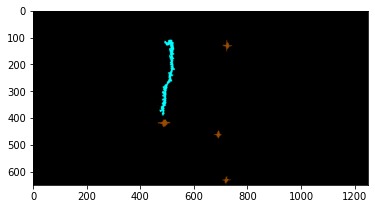

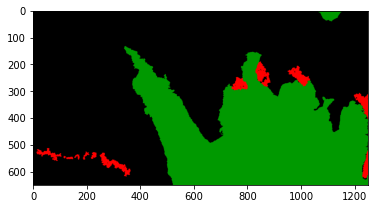

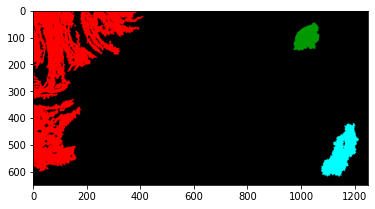

In [5]:
Y_test = []

for im_path in glob.glob("oil-spill-detection-dataset/test/labels/*.png"):
    Y = iio.imread(im_path)
    Y_test.append(Y)
    
plt.imshow(Y_test[0])
plt.show()
plt.imshow(Y_test[1])
plt.show()
plt.imshow(Y_test[2])
plt.show()


In [6]:
Y_train_1D = []

for im_path in glob.glob("oil-spill-detection-dataset/train/labels_1D/*.png"):
    Y = iio.imread(im_path)
    Y_train_1D.append(Y)

In [7]:
Y_test_1D = []

for im_path in glob.glob("oil-spill-detection-dataset/test/labels_1D/*.png"):
    Y = iio.imread(im_path)
    Y_test_1D.append(Y)

Checking if the lists that contain the images are as long as we would expect (1002 / 110) and check the dimensions of the individual arrays

In [15]:
print('length of X_train: ', len(X_train), ' shape of X_train: ', np.shape(X_train[0]))
print('length of Y_train: ', len(Y_train), ' shape of Y_train: ', np.shape(Y_train[0]))
print('length of Y_train_1D: ', len(Y_train_1D), ' shape of Y_train_1D: ', np.shape(Y_train_1D[0]))
print('length of X_test: ', len(X_test), ' shape of X_test: ', np.shape(X_test[0]))
print('length of Y_test: ', len(Y_test), ' shape of Y_test: ', np.shape(Y_test[0]))
print('length of Y_test_1D: ', len(Y_test_1D), ' shape of Y_test_1D: ', np.shape(Y_test_1D[0]))

length of X_train:  1442  shape of X_train:  (650, 1250, 3)
length of Y_train:  1002  shape of Y_train:  (650, 1250, 3)
length of Y_train_1D:  1002  shape of Y_train_1D:  (650, 1250)
length of X_test:  110  shape of X_test:  (650, 1250, 3)
length of Y_test:  110  shape of Y_test:  (650, 1250, 3)
length of Y_test_1D:  110  shape of Y_test_1D:  (650, 1250)


### Descriptive Statistics


Labels (Color - Meaning - Number in 1D Array):

Black - Sea Surface - 0

Cyan  - Oil Spill - 1

Red   - Look-alike - 2

Brown - Ship - 3

Green - Land - 4

Combining training and test data into one dataset to apply descriptive statistics

In [17]:
Y_1D = Y_train_1D + Y_test_1D

In [18]:
print('length of Y_1D: ', len(Y_1D))

length of Y_1D:  1112


Checking how many of the images contain oil

In [19]:
count = sum([np.any(arr == 1) for arr in Y_1D])
print('There are',count,'images containing oil spills.')
print((count/1112)*100,'% of all images contain oil spills.')

There are 879 images containing oil spills.
79.04676258992805 % of all images contain oil spills.


Counting the total number of pixels per class

In [20]:
counts1 = sum([np.count_nonzero(arr == 1) for arr in Y_1D])
print('Total amount of oil in pixels: ', counts1)
counts0 = sum([np.count_nonzero(arr == 0) for arr in Y_1D])
print('Total amount of sea surface in pixels: ', counts0)
counts2 = sum([np.count_nonzero(arr == 2) for arr in Y_1D])
print('Total amount of oil look alike in pixels: ', counts2)
counts3 = sum([np.count_nonzero(arr == 3) for arr in Y_1D])
print('Total amount of ship in pixels: ', counts3)
counts4 = sum([np.count_nonzero(arr == 4) for arr in Y_1D])
print('Total amount of land in pixels: ', counts4)

Total amount of oil in pixels:  9147574
Total amount of sea surface in pixels:  797785450
Total amount of oil look alike in pixels:  50465549
Total amount of ship in pixels:  357846
Total amount of land in pixels:  45743581


Calculating the average content of each image

In [21]:
counts=counts0+counts1+counts2+counts3+counts4
print('% of oil in pixels: ',(counts1/counts)*100,'%')
print('% of sea surface in pixels: ',(counts0/counts)*100,'%')
print('% of oil look alike in pixels: ',(counts2/counts)*100,'%')
print('% of ship in pixels: ',(counts3/counts)*100,'%')
print('% of land in pixels: ',(counts4/counts)*100,'%')

% of oil in pixels:  1.0124597675705589 %
% of sea surface in pixels:  88.29944106253458 %
% of oil look alike in pixels:  5.585561593801882 %
% of ship in pixels:  0.03960664084117321 %
% of land in pixels:  5.062930935251798 %


In [22]:
# Convert the list of arrays to a 2D NumPy array
data_array = np.vstack(Y_1D)

# Calculate descriptive statistics for the 2D array
print("Minimum:", np.min(data_array))
print("Maximum:", np.max(data_array))
print("Mean:", np.mean(data_array))
print("Median:", np.median(data_array))
print("Standard Deviation:", np.std(data_array))
print("Variance:", np.var(data_array))

Minimum: 0
Maximum: 4
Mean: 0.32554126618705037
Median: 0.0
Standard Deviation: 0.9701564269505794
Variance: 0.9412034927535148


Providing statistical proof that the data is not evenly distributed

In [23]:
# count the observed frequency of each value

observed_freq = [sum([np.count_nonzero(arr == 0) for arr in Y_1D]),
                 sum([np.count_nonzero(arr == 1) for arr in Y_1D]),
                 sum([np.count_nonzero(arr == 2) for arr in Y_1D]),
                 sum([np.count_nonzero(arr == 3) for arr in Y_1D]),
                 sum([np.count_nonzero(arr == 4) for arr in Y_1D])]


# Calculate the expected frequency of each value (assuming even distribution, using the average)
avg = (sum([np.count_nonzero(arr == 0) for arr in Y_1D])+
       sum([np.count_nonzero(arr == 1) for arr in Y_1D])+
       sum([np.count_nonzero(arr == 2) for arr in Y_1D])+
       sum([np.count_nonzero(arr == 3) for arr in Y_1D])+
       sum([np.count_nonzero(arr == 4) for arr in Y_1D]))/5

expected_freq = [avg, avg, avg, avg, avg]

# Use the chi-square test to check if the observed frequency is significantly different from the expected frequency
stat, pval = chisquare(observed_freq, expected_freq)

# Print the results
print("Observed frequency:", observed_freq)
print("Expected frequency:", expected_freq)
print("Chi-square test statistic:", stat)
print("P-value:", pval)
if pval < 0.1:
    print("The distribution is significantly different from even")
else:
    print("The distribution is not significantly different from even")

Observed frequency: [797785450, 9147574, 50465549, 357846, 45743581]
Expected frequency: [180700000.0, 180700000.0, 180700000.0, 180700000.0, 180700000.0]
Chi-square test statistic: 2644838003.5092564
P-value: 0.0
The distribution is significantly different from even


Creating a Histogram to visualize the distribution of classes among images

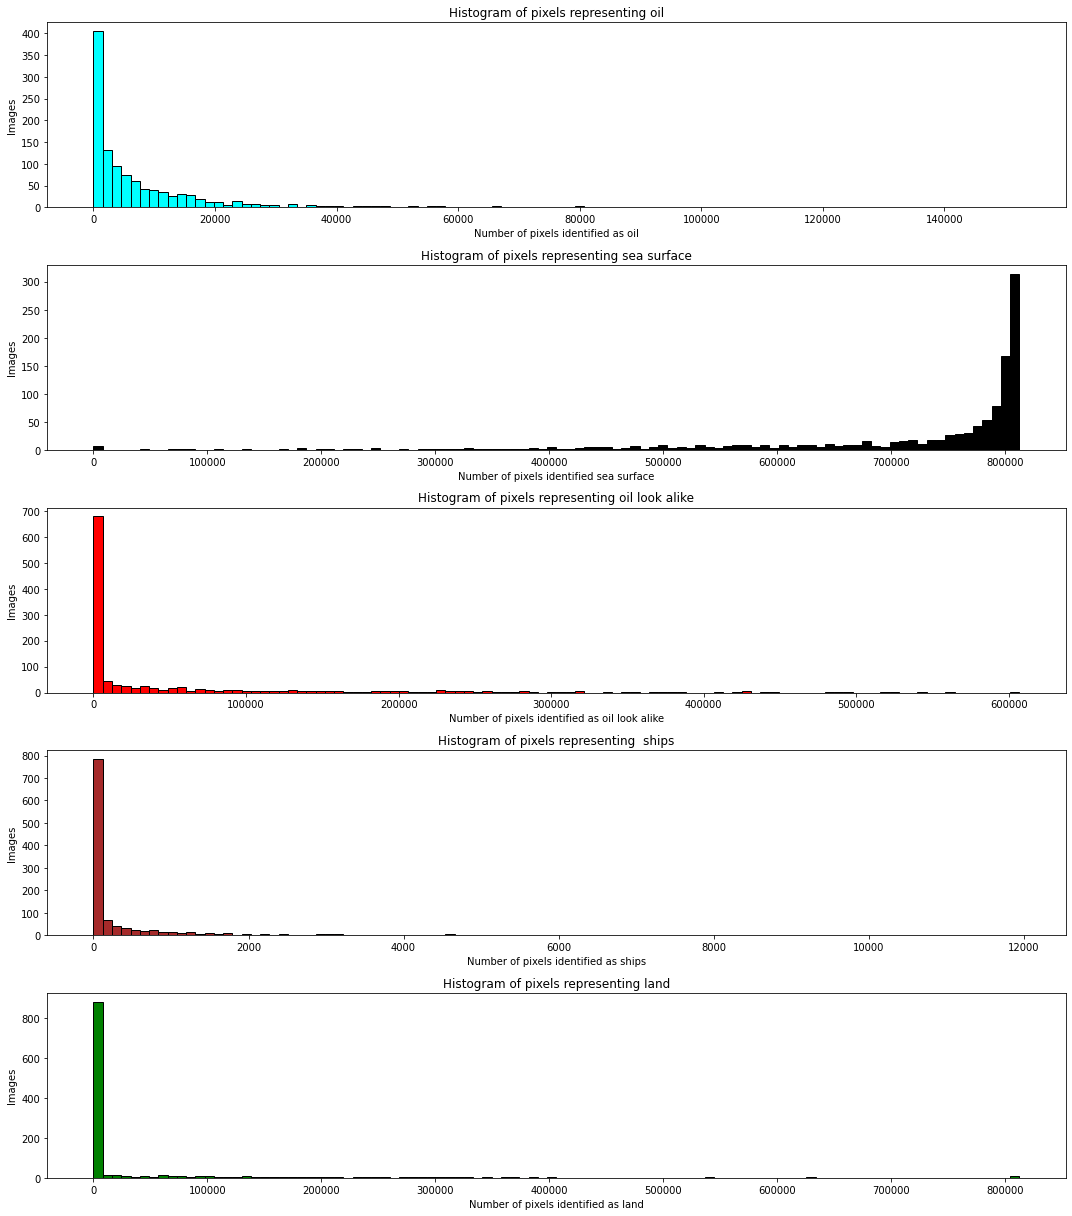

In [93]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 17))

counts = [np.count_nonzero(arr == 1) for arr in Y_1D]
axes[0].hist(counts, bins=100, edgecolor='black', color='cyan')
axes[0].set_xlabel('Number of pixels identified as oil')
axes[0].set_ylabel('Images')
axes[0].set_title('Histogram of pixels representing oil')

counts = [np.count_nonzero(arr == 0) for arr in Y_1D]
axes[1].hist(counts, bins=100, edgecolor='black', color='black')
axes[1].set_xlabel('Number of pixels identified sea surface')
axes[1].set_ylabel('Images')
axes[1].set_title('Histogram of pixels representing sea surface')
    
counts = [np.count_nonzero(arr == 2) for arr in Y_1D]
axes[2].hist(counts, bins=100, edgecolor='black', color='red')
axes[2].set_xlabel('Number of pixels identified as oil look alike')
axes[2].set_ylabel('Images')
axes[2].set_title('Histogram of pixels representing oil look alike')
    
counts = [np.count_nonzero(arr == 3) for arr in Y_1D]
axes[3].hist(counts, bins=100, edgecolor='black', color='brown')
axes[3].set_xlabel('Number of pixels identified as ships')
axes[3].set_ylabel('Images')
axes[3].set_title('Histogram of pixels representing  ships')
    
counts = [np.count_nonzero(arr == 4) for arr in Y_1D]
axes[4].hist(counts, bins=100, edgecolor='black', color='green')
axes[4].set_xlabel('Number of pixels identified as land')
axes[4].set_ylabel('Images')
axes[4].set_title('Histogram of pixels representing land')
    

plt.tight_layout()
plt.savefig('histogram.jpg', dpi=500)
plt.show()
    


### DeepLabV3+ Model

#### Data preparation

In [2]:
def create_dir (path):
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
def load_data (path, split=0.1):
    #load images
    X=sorted(glob(os.path.join(path, 'images', '*.jpg')))
    Y=sorted(glob(os.path.join(path, 'labels_1D', '*.png')))

    #training & validation split
    split_size = int(len(X)*split)
    train_x, val_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, val_y = train_test_split(Y, test_size=split_size, random_state=42)

    return(train_x, train_y), (val_x, val_y)

In [4]:
# Using data augmentation methods to create more data

def augment_data(images, label, save_path, augment=True):
    H = 640
    W = 1248
    for x, y in tqdm(zip (images, label), total=len(images)):
        #get name of file
        name = x.split('\\')[-1].split('.')[0]
        
        #reading image and label
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        #data augmentation
        if augment == True:
            aug = HorizontalFlip(p=1.0) 
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']
            
            aug = VerticalFlip(p=1.0) 
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = ChannelShuffle(p=1.0) 
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']
            
            aug = CoarseDropout(p=1.0, min_holes=3, max_holes= 10, max_height=32, max_width=32) 
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']
            
            aug = Rotate(limit=45, p=1.0) 
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            
            X = [x, x1, x2, x3, x4, x5]
            Y = [y, y1, y2, y3, y4, y5]
            
                  
        else:
            X = [x]
            Y = [y]
        index = 0    
        for i, l in zip (X, Y):
            try: 
                aug = CenterCrop(H, W, p=1.0)
                augmented = aug(image=i, label=l)
                i = augmented['image']
                l = augmented['mask']
            except Exception as e:    
                i = cv2.resize(i,(W,H))
                l = cv2.resize(l,(W,H))
            
            x_name_tmp= f"{name}_{index}.png"
            y_name_tmp= f"{name}_{index}.png"
            
            image_path = os.path.join(save_path, 'image', x_name_tmp)
            label_path = os.path.join(save_path, 'label', y_name_tmp)
            cv2.imwrite(image_path, i)
            cv2.imwrite(label_path, l)
            index+=1

Executing all the functions

In [161]:
path="training"
# Loading the Data
(train_x, train_y), (val_x, val_y) = load_data(path)

#Create directories to store data
create_dir('adj_training/train/image/')
create_dir('adj_training/train/label/')
create_dir('adj_training/val/image/')
create_dir('adj_training/val/label/')

#Data augmentation
augment_data(train_x, train_y, 'adj_training/train/', augment=False)
augment_data(val_x, val_y, 'adj_training/val/', augment=False)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.06it/s]


#### Model Architecture

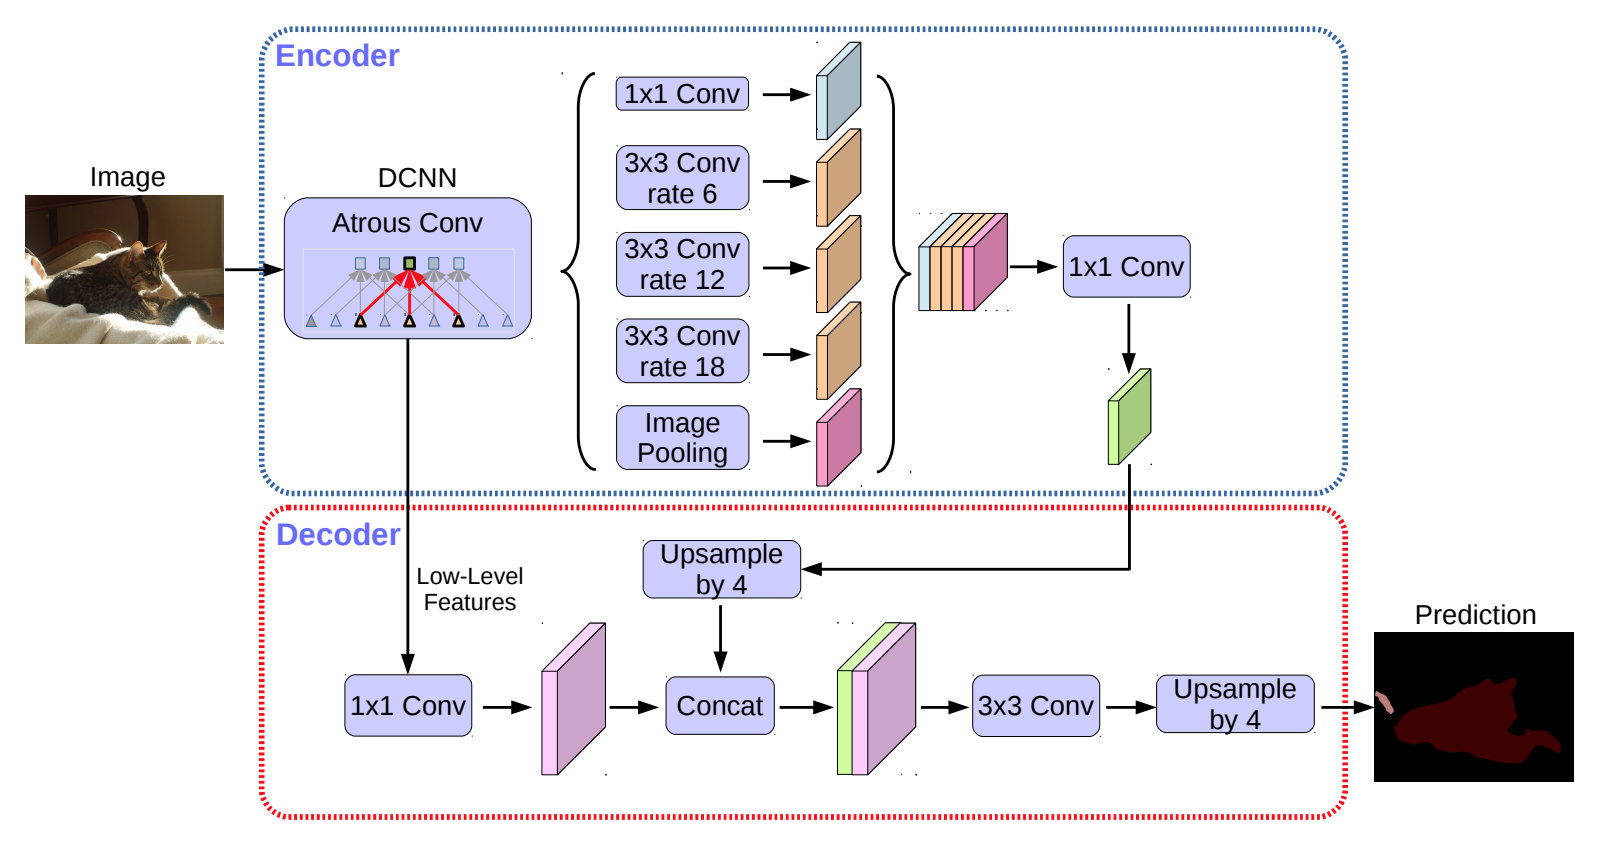
(Source: https://keras.io/examples/vision/deeplabv3_plus/)

In [63]:
# Global parameters
H = 640
W = 1248
NUM_CLASSES = 5
CLASSES = ['sea', 'oil', 'look alike', 'ship', 'ground']
CLASSMAP = (0,1,2,3,4)
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape= (1,1, filters)
    
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    
    se = Dense (filters//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense (filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    x= init * se
    return x


In [7]:
def ASPP(inputs):
    
    #Image Pooling
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding='same', use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)
    
    # 1x1 Convolution
    y2 = Conv2D(256, 1, padding='same', use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)

    # 3x3 Convolution with rate = 6
    y3 = Conv2D(256, 3, padding='same', use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)  
    
    # 3x3 Convolution with rate = 12
    y4 = Conv2D(256, 3, padding='same', use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)  
    
    # 3x3 Convolution with rate = 18
    y5 = Conv2D(256, 3, padding='same', use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5) 
    
    y = Concatenate()([y1, y2, y3, y4, y5])

    # 1x1 Convolution
    y = Conv2D(256, 1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    return y
    

In [8]:
def deeplabv3plus(shape):
    #Input
    
    inputs = Input(shape)
    
    #Encoder
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    
    # Upsample by 4
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    #Extract low level Features from encoder
    x_b = encoder.get_layer('conv2_block2_out').output

    # 1x1 Convolution
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)
  
    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)
    
    # 3x3 Convolution
    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 3x3 Convolution
    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SqueezeAndExcite(x)

    # Upsample by 4
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    
    #Output
    x = Conv2D(NUM_CLASSES,1)(x)
    x = Activation('softmax')(x)

    model = Model(inputs, x)
    return model



Executing the functions

In [9]:
model = deeplabv3plus((1248, 640, 3))
#size needs to be divisible by 16 (due to upsampling by 4 two times)


#### Training the Model

In [10]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [11]:
def load_files(path):
    x=sorted(glob(os.path.join(path, 'image', '*.png')))
    y=sorted(glob(os.path.join(path, 'label', '*.png')))
    return x,y

In [12]:
def read_i(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x.astype(np.float32)
    return x

def read_l_multiclass(path):   
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    
    output = []
    for c in CLASSMAP:
        mask = np.all(np.equal(x, c), axis=-1)
        output.append(mask)
    output = np.stack(output, axis=-1)
    output = output.astype(np.uint8)
    return output

In [13]:
def preprocess(ipath, lpath):
    def f (ipath, lpath):
        ipath=ipath.decode()
        lpath=lpath.decode()
        image=read_i(ipath)
        label=read_l_multiclass(lpath)
        return image, label
    image, label = tf.numpy_function(f, [ipath,lpath], [tf.float32, tf.uint8])
    image.set_shape([H,W,3])
    label.set_shape([H,W, NUM_CLASSES])
    return image, label

 

In [14]:
def tf_dataset(img, lab, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((img, lab))
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(5)

    return dataset

In [25]:
# Create folder to store files
create_dir('files')

# Hyperparameters
batch_size = 1 # 5 is maximum, after that out of memory error
lr = 1e-2
epochs = 2
model_path = os.path.join('files', 'model.h5')
csv_path = os.path.join('files', 'data.csv')

# Dataset

dataset_path = 'adj_training'
train_path = os.path.join(dataset_path, 'train') 
val_path = os.path.join(dataset_path, 'val') 

train_x, train_y = load_files(train_path)
valid_x, valid_y = load_files(val_path)

train_x, train_y = shuffling(train_x, train_y)


#Dataset pipeline
train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch = batch_size)
train_dataset
valid_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 640, 1248, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 640, 1248, 5), dtype=tf.uint8, name=None))>

In [20]:
model = deeplabv3plus((H, W, 3))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=[Recall(), Precision(), 'accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 640, 1248,   0           []                               
                                3)]                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 646, 1254, 3  0           ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 320, 624, 64  9472        ['conv1_pad[0][0]']              
                                )                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, 160, 312, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 160, 312, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 160, 312, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_blo

                                )                                                                 
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 80, 156, 128  512        ['conv3_block2_2_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 80, 156, 128  0          ['conv3_block2_2_bn[0][0]']      
 n)                             )                                                                 
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 80, 156, 512  66048       ['conv3_block2_2_relu[0][0]']    
                                )                                                                 
          

 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 40, 78, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 40, 78, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 40, 78, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block3_out (Activation)  (None, 40, 78, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 40, 78, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 40, 78, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 40, 78, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)       

                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 40, 78, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 1, 1, 1024)  0           ['conv4_block6_out[0][0]']       
 oling2D)                                                                                         
                                                                                                  
 conv2d_20 (Conv2D)             (None, 1, 1, 256)    262144      ['average_pooling2d_2[0][0]']    
                                                                                                  
 batch_nor

 tf.math.multiply_4 (TFOpLambda  (None, 160, 312, 30  0          ['concatenate_5[0][0]',          
 )                              4)                                'dense_9[0][0]']                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 160, 312, 25  700416      ['tf.math.multiply_4[0][0]']     
                                6)                                                                
                                                                                                  
 batch_normalization_25 (BatchN  (None, 160, 312, 25  1024       ['conv2d_27[0][0]']              
 ormalization)                  6)                                                                
                                                                                                  
 activation_27 (Activation)     (None, 160, 312, 25  0           ['batch_normalization_25[0][0]'] 
          

In [21]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)    
]

In [26]:
model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=callbacks)

Epoch 1/2
902/902 [==============================] - ETA: 0s - loss: 0.4090 - recall_1: 0.8696 - precision_1: 0.8890 - accuracy: 0.8794 
Epoch 1: val_loss improved from inf to 1578.54700, saving model to files\model.h5
902/902 [==============================] - 12908s 14s/step - loss: 0.4090 - recall_1: 0.8696 - precision_1: 0.8890 - accuracy: 0.8794 - val_loss: 1578.5470 - val_recall_1: 0.0992 - val_precision_1: 0.1575 - val_accuracy: 0.2537 - lr: 0.0100
Epoch 2/2
902/902 [==============================] - ETA: 0s - loss: 0.3499 - recall_1: 0.8806 - precision_1: 0.8993 - accuracy: 0.8893 
Epoch 2: val_loss improved from 1578.54700 to 1.89428, saving model to files\model.h5
902/902 [==============================] - 34809s 39s/step - loss: 0.3499 - recall_1: 0.8806 - precision_1: 0.8993 - accuracy: 0.8893 - val_loss: 1.8943 - val_recall_1: 0.0848 - val_precision_1: 0.1773 - val_accuracy: 0.3823 - lr: 0.0100


#### Testing with previously unseen data

In [28]:
#Load the weightfile of the model
model_path = os.path.join('files', 'model-2epoch-fulldataset.h5')
model = tf.keras.models.load_model(model_path)

In [30]:
def load_test_data (path):
    #load images
    X=sorted(glob(os.path.join(path, 'images', '*.jpg')))
    Y=sorted(glob(os.path.join(path, 'labels_1D', '*.png')))
    return X, Y 

In [77]:
# Replace class with RGB Value
def replace_pixels(image):
    
    
    # create a dictionary mapping classes to RGB values
    class_to_rgb = {
    0: [0, 0, 0],  # black
    1: [0, 255, 255],  # cyan
    2: [255, 0, 0],  # red
    3: [153, 76, 0],  # brown
    4: [0, 153, 0]  # green
    }

    # create a new 3D numpy array to hold the RGB values
    img_rgb = np.zeros(shape=(image.shape[0], image.shape[1], 3), dtype=np.uint8)

    # loop through the classes and assign the corresponding RGB values
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            img_rgb[i, j, :] = class_to_rgb[image[i, j]]

    return img_rgb

In [31]:
path="test"
# Loading the Data
(test_x, test_y) = load_test_data(path)

#Create directories to store data
create_dir('adj_test/image/')
create_dir('adj_test/label/')

#Data augmentation
augment_data(test_x, test_y, 'adj_test/', augment=False)

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:09<00:00, 11.11it/s]


In [83]:
dataset_path = 'adj_test'

test_x=sorted(glob(os.path.join(dataset_path, 'image', '*.png')))
test_y=sorted(glob(os.path.join(dataset_path, 'label', '*.png')))
SCORE=[]
LABELS=[]
PREDICTIONS=[]
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    # Get the name of the image
    name = x.split('\\')[-1].split('.')[0]
    
    #read image
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image_x = image
    image = np.expand_dims (image, axis=0)
    
    # reading label
    label = cv2.imread(y, cv2.IMREAD_COLOR)
    label_x = label 

    label_stack = []
    for c in CLASSMAP:
        mask = np.all(np.equal(label, c), axis=-1)
        label_stack.append(mask)
    label_stack = np.stack(label_stack, axis=-1)
    label_stack = np.argmax(label_stack, axis=-1)
    label_stack = label_stack.astype(np.int32)
    
    # Predicting
    pred = model.predict(image, verbose=0)[0]
    pred = np.argmax(pred, axis=-1)
    pred = pred.astype(np.int32)
    
    # Convert to RGB for plotting
    rgb_label = replace_pixels(label_stack)
    LABELS.append(rgb_label)
    rgb_pred = replace_pixels(pred)
    PREDICTIONS.append(rgb_pred)
        
    #Flatten the Arrays in order to compute scores
    pred_f = pred.flatten()
    label_f = label_stack.flatten()

    #Compute scores
    acc_value = accuracy_score(label_f, pred_f)
    f1_value = f1_score(label_f, pred_f, labels=[0, 1, 2, 3, 4], average='micro')
    jac_value = jaccard_score(label_f, pred_f, labels=[0, 1, 2, 3, 4], average='micro')
    recall_value = recall_score(label_f, pred_f, labels=[0, 1, 2, 3, 4], average='micro')
    precision_value = precision_score(label_f, pred_f, labels=[0, 1, 2, 3, 4], average='micro')
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

#Store scores in a csv file
   
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")     

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [11:04<00:00,  6.04s/it]

Accuracy: 0.80440
F1: 0.80440
Jaccard: 0.70705
Recall: 0.80440
Precision: 0.80440


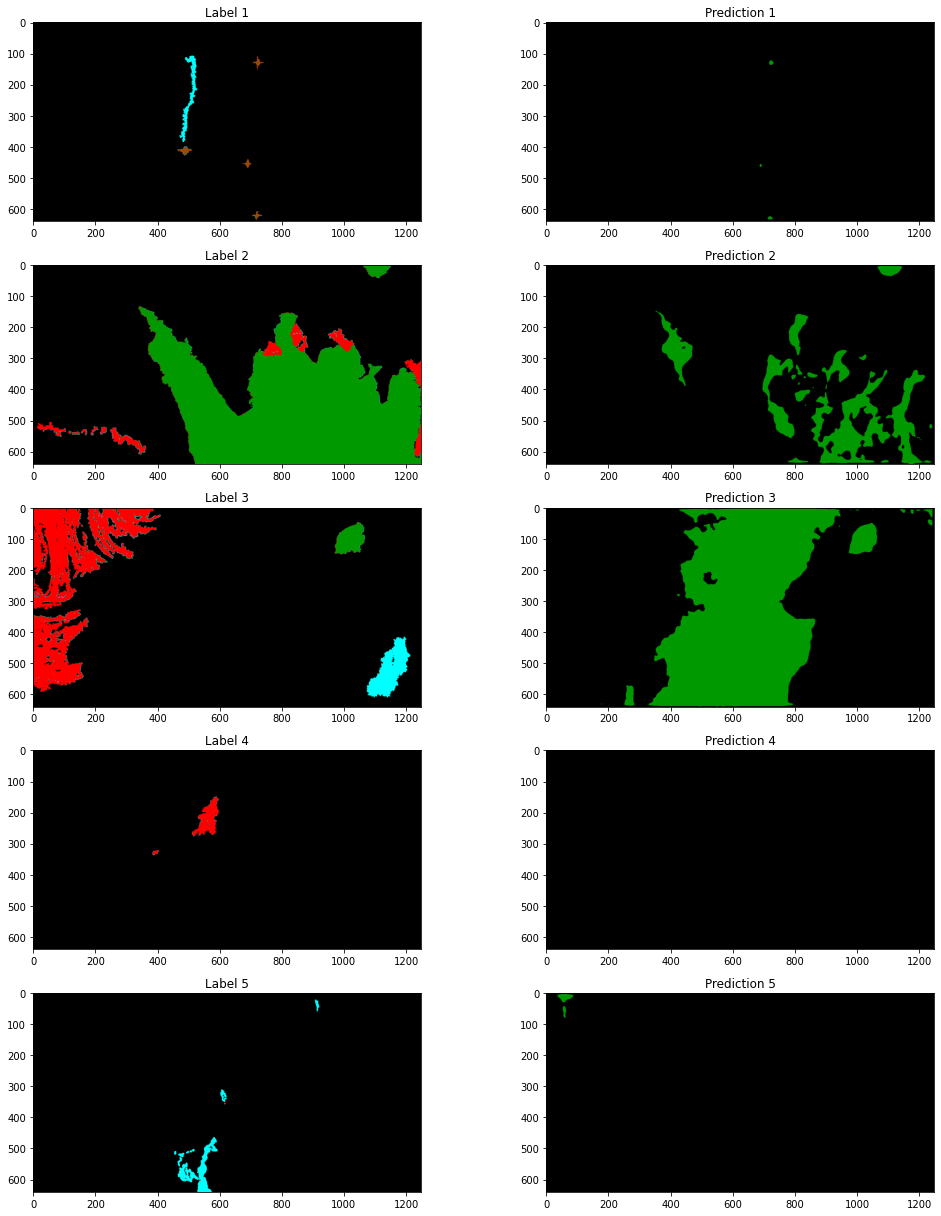

In [98]:
# Plotting some examples

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 17))

axes[0, 0].imshow(LABELS[0])
axes[0, 0].set_title('Label 1')

axes[0, 1].imshow(PREDICTIONS[0])
axes[0, 1].set_title('Prediction 1')
    
axes[1, 0].imshow(LABELS[1])
axes[1, 0].set_title('Label 2')
    
axes[1, 1].imshow(PREDICTIONS[1])
axes[1, 1].set_title('Prediction 2')
    
axes[2, 0].imshow(LABELS[2])
axes[2, 0].set_title('Label 3')

axes[2, 1].imshow(PREDICTIONS[2])
axes[2, 1].set_title('Prediction 3')

axes[3, 0].imshow(LABELS[3])
axes[3, 0].set_title('Label 4')

axes[3, 1].imshow(PREDICTIONS[3])
axes[3, 1].set_title('Prediction 4')

axes[4, 0].imshow(LABELS[4])
axes[4, 0].set_title('Label 5')

axes[4, 1].imshow(PREDICTIONS[4])
axes[4, 1].set_title('Prediction 5')
    

plt.tight_layout()
plt.show()
